# Tutorial para crear indicador sintético True-Range

In [3]:
####################################################################################
# Librerías de manejo de datos 
import pandas as pd
from pandas import concat
import numpy as np

####################################################################################
# Librerías de visualización
import matplotlib.pyplot as plt
from matplotlib import dates, ticker
from matplotlib.dates import (MONDAY, DateFormatter, MonthLocator, WeekdayLocator, date2num)
import matplotlib as mpl
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls
tls.set_credentials_file(username='raulMrello', api_key='qX9S30YRQ866mGF9b89u')


####################################################################################
# Librerías de gráficos de finanzas
from mpl_finance import candlestick_ohlc

####################################################################################
# TA-Lib: instalación y carga de la librería
import talib

####################################################################################
# Otras utilidades
import datetime
import time
import os
import sys

####################################################################################
print('Done!')

Done!


In [4]:
####################################################################################
# PASO 3: Carga el archivo csv en un dataframe, con posibilidad de rellenar espacios vacíos
def load_hist(filename, **kwargs):
    '''
        :param filename Archivo csv a leer
        :param kwargs lista de opciones:
            sep CSV Separator
            reindex_fillna Flag para rellenar espacios en blanco
            plot_it Flag para visualizar el archivo
        :return dataframe creado
    '''
    sep = ','
    reindex_fillna=False
    plot_it=False    
    if kwargs is not None:
        for key, value in kwargs.items():
            if key == 'sep': sep = value
            if key == 'reindex_fillna': reindex_fillna = value
            if key == 'plot_it': plot_it = value
                
    df = pd.read_csv(filename, sep=sep) 
    print(df.head(),'\r\n--------------------------')
    # crea una nueva columna de timestamp uniendo date & time y crea columnas para el día de la semana, el día del mes, el mes y la hora del día actual 
    df['timestamp'] = df['DATE'] + '  ' + df['TIME'] 
    df['timestamp'] = df['timestamp'].map(lambda x: datetime.datetime.strptime(x, '%Y.%m.%d %H:%M:%S'))  
    df['weekday'] = df['timestamp'].map(lambda x: x.dayofweek) 
    df['day'] = df['timestamp'].map(lambda x: x.day) 
    df['month'] = df['timestamp'].map(lambda x: x.month) 
    df['hhmm'] = df['timestamp'].map(lambda x: x.hour*60 + x.minute) 
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df[['timestamp','OPEN','HIGH','LOW','CLOSE','TICKVOL','VOL','SPREAD']]
    print(df.head(),'\r\n--------------------------')
    # establece como índice la columna de timestamp con una cadencia de 30min para encontrar los valores NaN
    if reindex_fillna:
        df.set_index('timestamp', inplace=True)
        df = df.reindex(pd.date_range(min(df.index), max(df.index), freq="1H"))
        # elimina los valores nulos y los rellena con el valor anterior
        df.fillna(method='ffill', inplace =True)
        print(df.head())
    if plot_it:
        plt.plot(df.OPEN)
        plt.plot(df.HIGH)
        plt.plot(df.LOW)
        plt.plot(df.CLOSE)
        plt.legend(['open','high','low','close'], loc='upper right')
    return df
        
    
####################################################################################
####################################################################################

df = load_hist('EURUSD_H1.csv',sep=';', reindex_fillna=True, plot_it=False)    
df = df.drop(columns=['TICKVOL','VOL','SPREAD'])
df.head()

         DATE      TIME    OPEN    HIGH     LOW   CLOSE  TICKVOL  VOL  SPREAD
0  2001.01.01  00:00:00  0.9421  0.9423  0.9419  0.9419        5    0      50
1  2001.01.01  08:00:00  0.9422  0.9424  0.9422  0.9424        2    0      50
2  2001.01.01  14:00:00  0.9425  0.9425  0.9425  0.9425        1    0      50
3  2001.01.01  15:00:00  0.9419  0.9419  0.9419  0.9419        1    0      50
4  2001.01.01  18:00:00  0.9397  0.9399  0.9390  0.9395       20    0      50 
--------------------------
            timestamp    OPEN    HIGH     LOW   CLOSE  TICKVOL  VOL  SPREAD
0 2001-01-01 00:00:00  0.9421  0.9423  0.9419  0.9419        5    0      50
1 2001-01-01 08:00:00  0.9422  0.9424  0.9422  0.9424        2    0      50
2 2001-01-01 14:00:00  0.9425  0.9425  0.9425  0.9425        1    0      50
3 2001-01-01 15:00:00  0.9419  0.9419  0.9419  0.9419        1    0      50
4 2001-01-01 18:00:00  0.9397  0.9399  0.9390  0.9395       20    0      50 
--------------------------
                    

,OPEN,HIGH,LOW,CLOSE
2001-01-01 00:00:00,0.9421,0.9423,0.9419,0.9419
2001-01-01 01:00:00,0.9421,0.9423,0.9419,0.9419
2001-01-01 02:00:00,0.9421,0.9423,0.9419,0.9419
2001-01-01 03:00:00,0.9421,0.9423,0.9419,0.9419
2001-01-01 04:00:00,0.9421,0.9423,0.9419,0.9419


## Cálculo TR respecto a HIGH y LOW

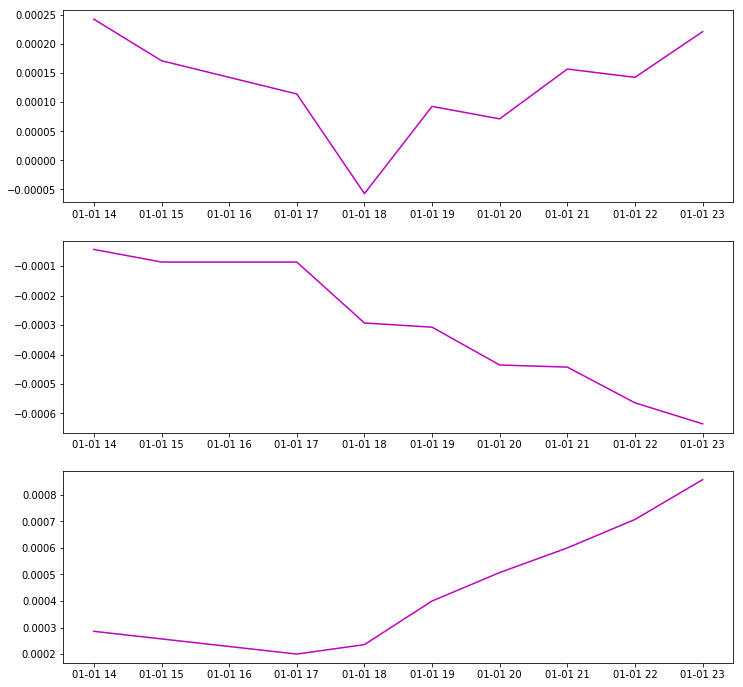

In [27]:
df['TRH'] = df.HIGH - df.CLOSE.shift(1)
df['TRH'] = talib.SMA(df['TRH'],timeperiod=14)
df['TRL'] = df.LOW - df.CLOSE.shift(1)
df['TRL'] = talib.SMA(df['TRL'],timeperiod=14)
df2 = df.dropna()
plt.figure(figsize=(12,12))
plt.subplot(3,1,1)
plt.plot(df2['TRH'][0:10],color='m')
plt.subplot(3,1,2)
plt.plot(df2['TRL'][0:10],color='m')
plt.subplot(3,1,3)
plt.plot((df2['TRH']-df2['TRL'])[0:10],color='m')

# Con Plot.ly

In [12]:
df_plotly = df[0:1000].copy()
trace = go.Candlestick(x=df_plotly.index,
                       open=df_plotly.OPEN,
                       high=df_plotly.HIGH,
                       low=df_plotly.LOW,
                       close=df_plotly.CLOSE)
data = [trace]
layout = go.Layout(
    autosize=False,
    width=1000,
    height=700,    
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)